# Introduction and Background

In [the previous notebook](1_LinearMethods.ipynb), we showed linear methods for learning atomic structures. In this notebook, we combine these supervised (LR) and unsupervised (PCA) models into one. 

As before, for each model, we first go step-by-step through the derivation, with equations, embedded links, and citations supplied where useful. At the end of the notebook, we demonstrate a "Utility Class" for the model, which is found in the utilities folder and contains all necessary functions.

In [1]:
#!/usr/bin/env python3

import sys

# Maths things
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Local Utilities for Notebook
sys.path.append('../')
from utilities.general import load_variables, sorted_eig
from utilities.plotting import (
    plot_projection, plot_regression, plot_simple, check_mirrors, get_cmaps, table_from_dict
)
from utilities.kernels import linear_kernel, gaussian_kernel, center_kernel
from utilities.classes import PCA, LR, PCovR

cmaps = get_cmaps()
plt.style.use('../utilities/kernel_pcovr.mplstyle')
dbl_fig=(2*plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][1])

First, we must load the data. For a step-by-step explanation of this, please see [Importing Data](X_ImportingData.ipynb).


In [2]:
var_dict = load_variables()
locals().update(var_dict)

20  frames in total.
Shape of Input Data is  (2872, 2520) .
Taking a subsampling of  200  columns
Splitting Data Set


# Fundamentals of Principal Covariates Regression (PCovR)

## Constructing the Loss and Similarity Functions

Principal Covariates Regression (PCovR) is a mathematical model that combines principal component analysis and linear regression (or more specifically, 
[principal components regression](https://en.wikipedia.org/wiki/Principal_component_regression)), with a parameter $\alpha$ that is used to 
tune the relative weight of each of the two tasks [(de Jong, 1992)](https://www.doi.org/10.1016/0169-7439(92)80100-I), 
[(Vervloet, 2015)](https://www.doi.org/10.18637/jss.v065.i08). 

\begin{equation}
\ell =
\alpha {\left\lVert \mathbf{X} - \mathbf{X}\mathbf{P}_{XT}\mathbf{P}_{TX}\right\rVert^2}
 +
(1-\alpha){\left\lVert \mathbf{Y} - \mathbf{X}\mathbf{P}_{XT}\mathbf{P}_{TY}\right\rVert^2}.
\end{equation}

It is easier to minimize this by looking for a projection $\mathbf{V}$ in a latent space for which we enforce orthonormality, $\mathbf{V}^T\mathbf{V} = \mathbf{I}$

\begin{equation}
\ell =
\alpha {\left\lVert \mathbf{X} - \mathbf{X}\mathbf{P}_{XV}\mathbf{P}_{VX}\right\rVert^2}
 +
(1-\alpha){\left\lVert \mathbf{Y} - \mathbf{X}\mathbf{P}_{XV}\mathbf{P}_{VY}\right\rVert^2}.
\end{equation}

$\mathbf{V}$ is the [whitened](https://en.wikipedia.org/wiki/Whitening_transformation) version of our earlier projection $\mathbf{T}$.

By definition, $\mathbf{X}\mathbf{P}_{XV} = \mathbf{V}$. Due to orthogonality, the definition $\mathbf{V}\mathbf{P}_{VX} = \mathbf{X}$ implies that $\mathbf{P}_{VX} = \mathbf{V}^T
 \mathbf{X}$. Similarly, we find  $\mathbf{P}_{VY} = \mathbf{V}^T\mathbf{Y}$, leading to

\begin{equation}
    \ell = \alpha\lVert\mathbf{X} - \mathbf{V}\mathbf{V}^T\mathbf{X}\rVert^2 + (1 - \alpha)\lVert\mathbf{Y} - \mathbf{V}\mathbf{V}^T\mathbf{Y}\rVert^2.
\end{equation}

**Note**: if the features and the properties were not normalized, it would be advisable to do so here, by dividing the first term by ${\lVert \mathbf{X} \rVert^2}$ and the second by ${\Vert \mathbf{Y} \rVert^2}$, to make sure that the two components are compared on equal footings, without introducing a dependence on their absolute magnitude.


Just like with [PCA](1_LinearMethods.ipynb), instead of minimizing loss, we maximize the similarity measure, leading to:

\begin{equation}
\rho = \operatorname{Tr}\left(\alpha \cdot \mathbf{V}\mathbf{V}^T\mathbf{X}\mathbf{X}^T + \left(1-\alpha\right)\mathbf{V}\mathbf{V}^T\mathbf{Y}\mathbf{Y}^T\right),
\end{equation}

where $\rho$ is obtained from $\ell$ by exploiting the invariance of the trace to circular permutations, and dropping constant terms. 

## Combining X- and Y-Space

An important detail to consider is that we are looking for an approximation of the properties based on a reduced-dimensional latent space that depends only on the  $\mathbf{X}$ features. In order to avoid considering components of the properties that cannot be represented even in the full feature space, we must first project our properties onto $\mathbf{X}$.

For this, we use the least-squares approximation of $\mathbf{Y}$ as found in [linear regression](1_LinearMethods.ipynb).

\begin{equation}
\hat{\mathbf{Y}} = \mathbf{X}\mathbf{P}_{XY} = \mathbf{X}\left(\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I}\right)^{-1}\mathbf{X}^T \mathbf{Y}
\end{equation}

where $\lambda$ is the regularization parameter.

In [3]:
regularization=1e-6

lr = LR(regularization=regularization)
lr.fit(X_train, Y_train)
Yhat_train = lr.transform(X_train).reshape((-1, Y_train.shape[1]))

Given that (when $\lambda$ is small) $\operatorname{Tr}(\mathbf{VV}^T\mathbf{Y}\mathbf{Y}^T) = \operatorname{Tr}(\mathbf{VV}^T\mathbf{\hat{Y}}\mathbf{\hat{Y}}^T)$ we write the similarity function as

\begin{equation}
\rho = \operatorname{Tr}\left(\alpha \cdot \mathbf{VV}^T\mathbf{X}\mathbf{X}^T + \left(1-\alpha\right)\mathbf{VV}^T\mathbf{\hat{Y}}\mathbf{\hat{Y}}^T\right),
\end{equation}

## Formulations of PCovR

In the similarity measure we have the matrix product $\mathbf{XX}^T$. This matrix becomes too large to handle if $\mathbf{X}$ has many more rows (samples) than columns (features). Therefore, two formulations of PCovR have been proposed: one for cases where $n_{samples} \gg n_{features}$, and the other for cases where $n_{features} \gg n_{samples}$. The former we refer to as **feature space PCovR** (which is analogous to PCA), and we refer to the latter as **sample space PCovR** (which is analogous to MDS).
We begin by discussing sample space PCovR.

# Sample-Space PCovR

To compute PCovR using the all $n_{samples}$ components of our structure space, we must combine the sample-space kernel ($\mathbf{X}\mathbf{X}^T$) and the outer product of the regressed properties ($\hat{\mathbf{Y}}\hat{\mathbf{Y}}^T$). 

We define the modified [Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix)

\begin{equation}
    \mathbf{\tilde{K}} = \alpha {\mathbf{X} \mathbf{X}^T}
    + (1 - \alpha) {\hat{\mathbf{Y}} \hat{\mathbf{Y}}^T},
\end{equation}

such that one can
write $\rho = \operatorname{Tr}\left(\mathbf{V}^T\mathbf{\tilde{K}}\mathbf{V}\right)$, that is maximized when $\mathbf{V}$ contains the principal eigenvectors of $\mathbf{\tilde{K}}$ (i.e., the eigenvectors associated with the largest eigenvalues). 

<!--This formulation of $\mathbf{\tilde{K}}$ is analogous of a [linear kernel](http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/#linear), as the two terms are expressed as dot products.-->

In [4]:
alpha = 0.5

K_pca = np.matmul(X_train, X_train.T)
K_lr  = np.matmul(Yhat_train, Yhat_train.T)
    
K = (alpha*K_pca) + (1.0-alpha)*K_lr

What follows is analogous to multi-dimensional scaling, with $\mathbf{\tilde{K}}$ acting as the Gram matrix, modified to weight structural and property correlations. 
First, we diagonalize $\mathbf{\tilde{K}}=\mathbf{U_\tilde{K}}\mathbf{\Lambda_\tilde{K}}\mathbf{U_\tilde{K}}^T$.

In [5]:
v_Kt, U_Kt = sorted_eig(K, thresh=1e-12)

U_Kt = U_Kt[:, v_Kt>0]
v_Kt = v_Kt[v_Kt>0]

/Users/rosecers/Programs/miniconda/lib/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


$\mathbf{V} = \mathbf{\hat{U}_\tilde{K}}$, where $\mathbf{\hat{U}_\tilde{K}}$ contains the first $n_{PCA}$ components of $\mathbf{U_\tilde{K}}$.

While it is useful to construct our loss and similarity using the whitened matrix $\mathbf{V}$, in doing so we lose information on the relative variance of the different components of the input space. To recover the MDS limit when $\alpha=1$, we build projections by "de-whitening" the principal eigenvectors by multiplying by a factor of $\mathbf{\Lambda_\tilde{K}}^{1/2}$, i.e.
$\mathbf{T} = \mathbf{V} \mathbf{\Lambda_\tilde{K}}^{1/2} = \mathbf{P}_{XV}  \mathbf{\Lambda_\tilde{K}}^{1/2} $.

In [6]:
T = np.matmul(U_Kt[:,:n_PC],np.diagflat(np.sqrt(v_Kt[:n_PC])) )

## Determining the Projector $\mathbf{P}_{XT}$

We also derive a projector from $X$ space directly to the latent space in the form of $\mathbf{T} = \mathbf{XP}_{XT}$ (and vice versa). For that we need to solve 
\begin{equation}
\mathbf{X}\mathbf{P}_{XT} = \mathbf{V} \mathbf{\Lambda_\tilde{K}}^{1/2} =  \mathbf{\tilde{K}}\mathbf{U}_\tilde{K} \mathbf{\Lambda}_\tilde{K}^{-1/2},
\end{equation}

where we used the fact that $\mathbf{V}$ is built from columns of $\mathbf{\hat{U}_{\tilde{K}}}$.
Writing explicitly $\mathbf{\tilde{K}}$ and $\hat{\mathbf{Y}}$,

\begin{align}
\mathbf{X}\mathbf{P}_{XT} &= \left( 
\alpha \mathbf{X} \mathbf{X}^T
+ (1 - \alpha) 
\mathbf{X}\left(\mathbf{X}^T\mathbf{X}\right)^{-1}\mathbf{X}^T \mathbf{Y}
\hat{\mathbf{Y}}^T
\right)  \mathbf{U}_\tilde{K} \mathbf{\Lambda}_\tilde{K}^{-1/2} \\
&= \mathbf{X} \left( 
\alpha \mathbf{X}^T
+ (1 - \alpha) 
\left(\mathbf{X}^T\mathbf{X}\right)^{-1}\mathbf{X}^T \mathbf{Y}
\hat{\mathbf{Y}}^T
\right)  \mathbf{U}_\tilde{K} \mathbf{\Lambda}_\tilde{K}^{-1/2}.
\end{align}

we obtain the projector from feature to latent space $\mathbf{P}_{XT}$ explicitly 

\begin{equation}
\mathbf{P}_{XT} = \left(
\alpha{\mathbf{X}^T}
+ (1 - \alpha)
\left(\mathbf{X}^T\mathbf{X}\right)^{-1}\mathbf{X}^T \mathbf{Y}
\hat{\mathbf{Y}}^T
\right)  \mathbf{U}_\tilde{K} \mathbf{\Lambda}_\tilde{K}^{-1/2}.
\end{equation}



In [7]:
P_lr = np.matmul(X_train.T, X_train) + np.eye(X_train.shape[1])*regularization
P_lr = np.linalg.pinv(P_lr)
P_lr = np.matmul(P_lr, X_train.T)
P_lr = np.matmul(P_lr, Y_train).reshape((-1, Y_train.shape[1]))
P_lr = np.matmul(P_lr, Yhat_train.T)

P_pca =  X_train.T
    
P = (alpha*P_pca) + (1.0-alpha)*P_lr
PXT = np.matmul(P,np.matmul(U_Kt[:,:n_PC], np.diag(1/np.sqrt(v_Kt[:n_PC])) ))

We verify that $\mathbf{T}\approx \mathbf{X}\mathbf{P}_{XT}$.

In [8]:
print(np.linalg.norm(np.matmul(X_train, PXT)-T))

6.186635143920972e-14


And plot the projection. Note how the position of points in latent space correlates much better with the properties than they do in PCA latent space

In [9]:
X_pcovr_test = np.matmul(X_test, PXT)

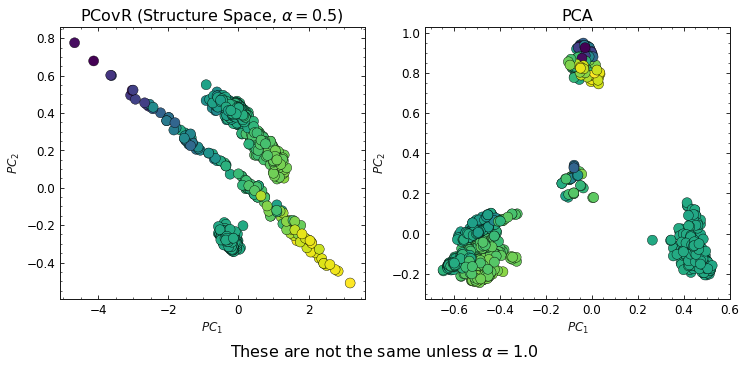

In [10]:
fig, axes = plt.subplots(1,2, figsize=dbl_fig)

ref = PCA(n_PC=n_PC)
ref.fit(X_train)
x_ref = ref.transform(X_test)

plot_projection(Y_test, check_mirrors(X_pcovr_test, x_ref), fig=fig, ax=axes[0],  title = r"PCovR (Structure Space, $\alpha={}$)".format(alpha), **cmaps)
plot_projection(Y_test, x_ref, fig=fig, ax=axes[1],  title = "PCA", **cmaps)

fig.suptitle(r"These are not the same unless $\alpha = 1.0.$", y=0.0, fontsize=plt.rcParams['font.size']+6)
plt.show()

The image on the left (PCovR) is the 2D projected that is weighted by a factor of (1-$\alpha$) towards those axes which best discern the properties $\mathbf{Y}$. 

The image to the right (PCA) is the 2D projection which best preserves the variance of the feature matrix $\mathbf{X}$.

## Predicting the Properties
Now how do we get the weights to predict the properties? Basically we need to 
solve the linear regression problem in the projected space, i.e., solve for the weights $\mathbf{P}_{TY}$ such that:

\begin{equation}
\mathbf{Y_{PCovR}} = \mathbf{T} \mathbf{P}_{TY} = \mathbf{X} \mathbf{P}_{XT} \mathbf{P}_{TY}. 
\end{equation}

We determine the regression parameter $\mathbf{P}_{TY}$ by applying the usual LR expression using the projections $\mathbf{T}$.

\begin{equation}
\mathbf{P}_{TY} = (\mathbf{T}^T\mathbf{T})^{-1}\mathbf{T}^T\mathbf{Y} = 
 \mathbf{\Lambda_\tilde{K}}^{-1}\mathbf{T}^T\mathbf{Y},
\end{equation}

Where the factor of $\mathbf{\Lambda_\tilde{K}}^{-1}$ arises from the fact that
$\mathbf{T}^T\mathbf{T}=\mathbf{\Lambda_\tilde{K}}^{1/2}\mathbf{U_\tilde{K}}^T\mathbf{U_\tilde{K}}\mathbf{\Lambda_\tilde{K}}^{1/2}=
\mathbf{\Lambda_\tilde{K}}$. Note that $\mathbf{Y}$ corresponds to the property vector for the train set.

**Note:** this differs from the expression in [2015 paper on PCovR](https://www.doi.org/10.18637/jss.v065.i08), which uses the whitened PCA projections $\mathbf{V}=\mathbf{U_\tilde{K}}$ with variance 1. Here, we construct our PCA projections without this normalization, so we must divide by the eigenvalue matrix to compute regression weights.

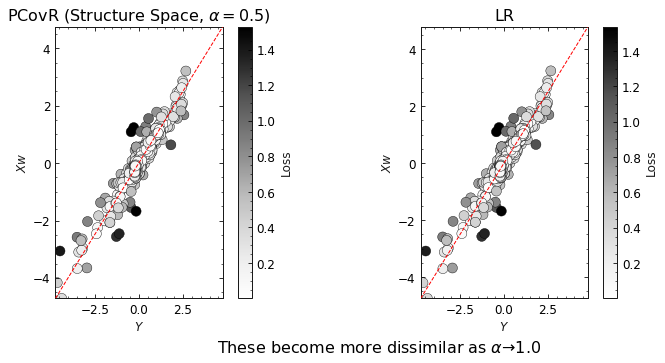

In [11]:
PTY = np.matmul(np.diagflat(1/(v_Kt[:n_PC])),np.matmul(T.T, Y_train))
Y_pcovr_test  = np.matmul(np.matmul(X_test, PXT), PTY)

fig, axes = plt.subplots(1,2, figsize=dbl_fig)

ref_lr = LR(regularization=regularization)
ref_lr.fit(X_train, Y_train)
yref = lr.transform(X_test)

plot_regression(Y_test[:,0], Y_pcovr_test[:,0], fig=fig, ax=axes[0], title = r"PCovR (Structure Space, $\alpha={}$)".format(alpha), **cmaps)
plot_regression(Y_test[:,0], yref[:,0], fig=fig, ax=axes[1], title = "LR", **cmaps)

fig.suptitle(r"These become more dissimilar as $\alpha \to 1.0.$", y=0.01, fontsize=plt.rcParams['font.size']+6)
plt.show()

# Feature-Space PCovR

## The Similarity Function in Feature-Space

In the case where the number of samples is greater than the number of features ($n_{samples} >> n_{features}$), computing the eigenvectors of $\mathbf{\tilde{K}}$ may be undesirable. In this case, we instead compute the eigenvectors of the $n_{features} \times n_{features}$ matrix, i.e., the feature space. In order to formulate a feature-space version of PCovR we again consider how PCovR maximises the similarity ($\rho$) between our projection and the original data.

\begin{equation}
\rho = \operatorname{Tr}\left(\mathbf{V}^T\mathbf{\tilde{K}}\mathbf{V}\right)
\end{equation}

and rewrite it in terms of the decomposition $\mathbf{V} = \mathbf{X}\mathbf{P}_{XV}$

\begin{align}
\rho &= \operatorname{Tr}\left(\mathbf{P}_{XV}^T\mathbf{X}^T\mathbf{\tilde{K}}\mathbf{X}\mathbf{P}_{XV}\right)
\end{align}

$\mathbf{X}^T\mathbf{\tilde{K}}\mathbf{X}$ is a $n_{features}\times n_{features}$ matrix, so why not solve for $\mathbf{P}_{XV}$ through an eigendecomposition of $\mathbf{X}^T\mathbf{\tilde{K}}\mathbf{X}$?

For this trick to work, we need to work with an orthogonal matrix, and $\mathbf{P}_{XV}$ is not! However $\mathbf{P}_{XV}^T\mathbf{C}\mathbf{P}_{XV} = \mathbf{P}_{XV}^T\mathbf{X}^T\mathbf{X}\mathbf{P}_{XV} = \mathbf{V}^T\mathbf{V} = \mathbf{I} $.

In [12]:
C = np.matmul(X_train.T,X_train)

PXV = np.matmul(PXT, np.diagflat(1.0/np.sqrt(v_Kt[:n_PC])))

print(np.linalg.norm(np.matmul(PXV.T, np.matmul(C, PXV)) - 
                     np.eye(PXV.shape[1])))

2.2016837855981317e-15


Therefore $\mathbf{C}^{1/2}\mathbf{P}_{XV}$ is orthogonal! 

We calculate $\mathbf{C}^{1/2}$ and $\mathbf{C}^{-1/2}$ using the eigendecomposition of $\mathbf{C}$, given

\begin{align}
& \mathbf{C}^{1/2} = \mathbf{U}_C \mathbf{\Lambda}^{1/2} \mathbf{U}_C^T\\
& \mathbf{C}^{-1/2} = \mathbf{U}_C \mathbf{\Lambda}^{-1/2} \mathbf{U}_C^T\\
\end{align}

In [13]:
v_C, U_C = sorted_eig(C, thresh=1e-12)

Csqrt = np.matmul(np.matmul(U_C, np.diagflat(np.sqrt(v_C))), U_C.T)
iCsqrt = np.matmul(np.matmul(U_C, np.diagflat(1.0/np.sqrt(v_C))), U_C.T)

We then write

\begin{align}
\rho &= \operatorname{Tr}\left(\mathbf{P}_{XV}^T\mathbf{C}^{1/2}\mathbf{C}^{-1/2}\mathbf{X}^T\mathbf{\tilde{K}}\mathbf{X}\mathbf{C}^{1/2}\mathbf{C}^{-1/2}\mathbf{P}_{XV}\right)
\end{align}

and introduce a modified covariance matrix $\tilde{\mathbf{C}}$

\begin{equation}
\tilde{\mathbf{C}} = \mathbf{C}^{-1/2}\mathbf{X}^T\mathbf{\tilde{K}}\mathbf{X}\mathbf{C}^{-1/2}
\end{equation}

In [14]:
Ct = np.matmul(iCsqrt, X_train.T)
Ct = np.matmul(np.matmul(Ct, K), Ct.T)

v_Ct, U_Ct = sorted_eig(Ct, thresh=0)
U_Ct = U_Ct[:, v_Ct>0]
v_Ct = v_Ct[v_Ct>0]

We verify that $\mathbf{\tilde{C}}$ and $\mathbf{\tilde{K}}$ have the same eigenvalues, as they're connected to each other by the same relation that links the covariance and the Gram matrix. As such, the blue and red lines in the figure below should be indistinguishable.

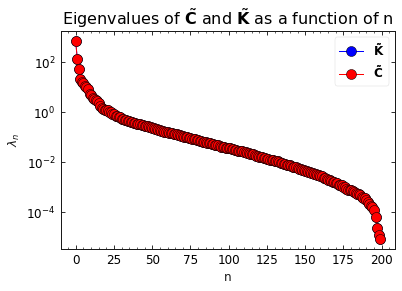

In [15]:
fig, ax = plt.subplots(1)
ax.set_yscale('log')
ax.plot(v_Kt, 
        marker='o',
        c='b', label=r'$\mathbf{\tilde{K}}$')
ax.plot(v_Ct, 
        marker='o',
        c='r', label=r'$\mathbf{\tilde{C}}$')
ax.set_xlabel("n"); ax.set_ylabel('$\lambda_n$');
ax.set_title(r"Eigenvalues of $\mathbf{\tilde{C}}$ and $\mathbf{\tilde{K}}$ as a function of n")
ax.legend()
plt.show()

## Computing the Projectors

The similarity is maximized when the orthogonal matrix $\mathbf{C}^{1/2}\mathbf{P}_{XV}$ matches the principal eigenvalues of $\mathbf{\tilde{C}}$, i.e. $\mathbf{P}_{XV} = \mathbf{C}^{-1/2}\hat{\mathbf{U}}_{\mathbf{\tilde{C}}}$.

In [16]:
PXV = np.matmul(iCsqrt, U_Ct[:,:n_PC])

In general
$\mathbf{P}_{XV} \mathbf{P}_{VX} = \mathbf{C}^{-1/2}\hat{\mathbf{U}}_{\mathbf{\tilde{C}}}\hat{\mathbf{U}}_{\mathbf{\tilde{C}}}^T \mathbf{C}^{1/2}$ is not a symmetric matrix, and so it is not possible to define an orthonormal $\mathbf{P}_{XT}$ such that $\mathbf{P}_{TX}=\mathbf{P}_{XT}^{T}$. 
Consistently with the case of sample-space PCovR, we define 

\begin{equation}
\begin{split}
\mathbf{P}_{XT} =& \mathbf{C}^{-1/2}\hat{\mathbf{U}}_{\mathbf{\tilde{C}}}\hat{\mathbf{\Lambda}}_{\mathbf{\tilde{C}}}^{1/2} \\
\mathbf{P}_{TX} =& \hat{\mathbf{\Lambda}}_{\mathbf{\tilde{C}}}^{-1/2} \hat{\mathbf{U}}_{\mathbf{\tilde{C}}}^T  \mathbf{C}^{1/2} \\
\mathbf{P}_{TY} =& \hat{\mathbf{\Lambda}}_{\mathbf{\tilde{C}}}^{-1/2} \hat{\mathbf{U}}_{\mathbf{\tilde{C}}}^T  \mathbf{C}^{-1/2} \mathbf{X}^T \mathbf{Y}, \\
\end{split}
\label{eq:pcovr-projectors}
\end{equation}

In [17]:
PXT = np.matmul(PXV, np.diagflat(np.sqrt(v_Ct[:n_PC])))
PTX = np.matmul(np.diagflat(1.0/np.sqrt(v_Ct[:n_PC])), 
                np.matmul(U_Ct[:, :n_PC].T, Csqrt)) 
PTY = np.matmul(np.diagflat(1.0/np.sqrt(v_Ct[:n_PC])),
                U_Ct[:,:n_PC].T)
PTY = np.matmul(PTY, iCsqrt)
PTY = np.matmul(np.matmul(PTY, X_train.T), 
                Y_train)

## Projecting the Data
Projecting and regressing in feature-space PCovR proceeds similarly to Structure Space PCovR:

In [18]:
X_fspcovr_test = np.matmul(X_test, PXT)

Y_fspcovr_test  = np.matmul(np.matmul(X_test, PXT), PTY)

We compare with the Structure Space PCovR and see that the results are essentially identical:

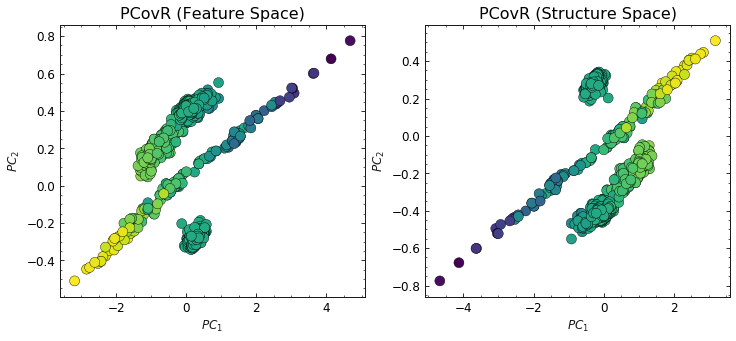

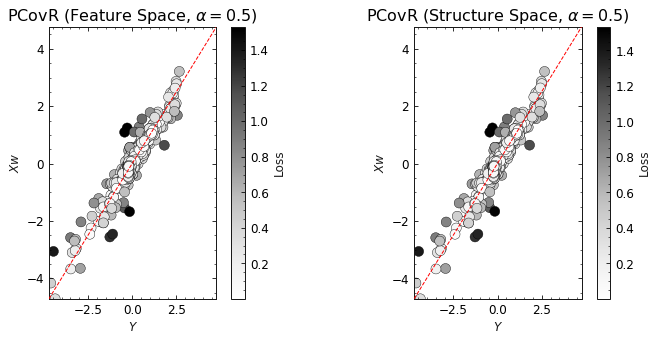

In [19]:
fig, axes = plt.subplots(1,2, figsize=dbl_fig)

ref = PCovR(alpha=alpha, n_PC=2, space="structure")
ref.fit(X_train, Y_train)
tref, yref, xref = ref.transform(X_test)

plot_projection(Y_test, check_mirrors(X_fspcovr_test, xref), fig=fig, ax=axes[0], title = "PCovR (Feature Space)", **cmaps)
plot_projection(Y_test, tref, fig=fig, ax=axes[1], title = "PCovR (Structure Space)", **cmaps)

fig, axes = plt.subplots(1,2, figsize=dbl_fig)

plot_regression(Y_test[:,0], Y_fspcovr_test[:,0], fig=fig, ax=axes[0], title = r"PCovR (Feature Space, $\alpha={}$)".format(alpha), **cmaps)
plot_regression(Y_test[:,0], yref[:,0], fig=fig, ax=axes[1], title = r"PCovR (Structure Space, $\alpha={}$)".format(alpha), **cmaps)

plt.show()

# PCovR Performance

To determine the sensitivity of PCovR to the value of $\alpha$ and the number of PCA components, it is instructive to visualize the dependence of the projections and to the different components of the loss on these parameters. We do so using the utility classes.

In [20]:
n_alphas = 11
alphas = np.linspace(0.0, 1.0, n_alphas)
components = np.arange(0, 5, 1, dtype=np.int)[2::]
n_components = components.size

pcovr_calculators = np.array([[PCovR(alpha=a, n_PC=c, space="feature") for a in alphas] 
                                                                        for c in components])

for cdx, c in enumerate(components):
    for adx, a in enumerate(alphas):
        pcovr_calculators[cdx][adx].fit(X_train, Y_train)

## Comparison of PCovR Projections and Regressions

To use PCovR, it's useful to get an intuitive sense for the change in the projections and regressions across $\alpha$, and see the trade-off. Below we plot both projections and regressions for $n_{\alpha}$ different values of $\alpha$.

**Note**: Remember that in PCA-like projection, sometimes projections of the same data may be related by mirror reflection. For these projections, this may also occur.

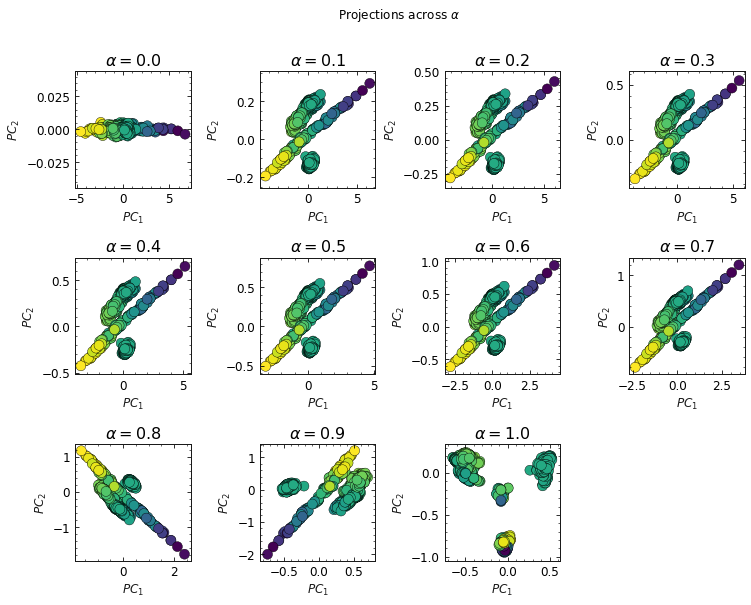

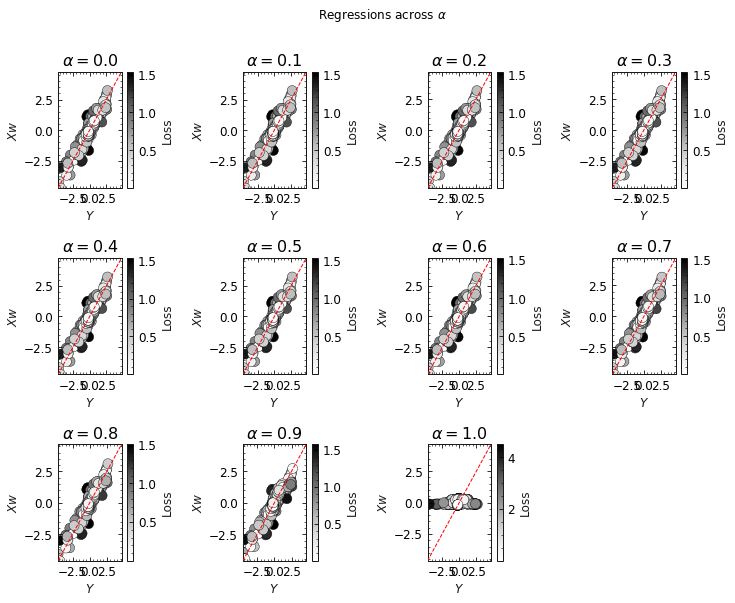

In [21]:
n_plots = int(n_alphas ** 0.5)
scale = 3

t_ref, y_ref, x_ref = pcovr_calculators[0][-3].transform(X_test)

pfig, pax = plt.subplots(n_plots, int(np.ceil(n_alphas/n_plots)),
                                   figsize=(scale*int(np.ceil(n_alphas/n_plots)), scale*n_plots,),
                                  )

rfig, rax = plt.subplots(n_plots, int(np.ceil(n_alphas/n_plots)),
                                   figsize=(scale*int(np.ceil(n_alphas/n_plots)), scale*n_plots,),
                                  )
for p, r, pcovr in zip(pax.flatten(), rax.flatten(), pcovr_calculators[0]):

    t,y,x = pcovr.transform(X_test)
    
    plot_projection(Y_test, check_mirrors(t, t_ref), fig=pfig, ax=p, **cmaps, alpha=1.0)
    
    plot_regression(Y_test[:,0], y[:,0], fig=pfig, ax=r, **cmaps, alpha=1.0)
    
    p.set_title(r"$\alpha=$"+str(round(pcovr.alpha,3)))
    r.set_title(r"$\alpha=$"+str(round(pcovr.alpha,3)))

    
for p, r in zip(pax.flatten()[n_alphas:], rax.flatten()[n_alphas:]):
    p.axis('off')
    r.axis('off')
    
pfig.subplots_adjust(wspace=0.6, hspace=0.6)
pfig.suptitle(r"Projections across $\alpha$")
rfig.subplots_adjust(wspace=0.6, hspace=0.6)
rfig.suptitle(r"Regressions across $\alpha$")

plt.show()

## Comparison of PCovR Loss Terms
To get a more quantitative assessment of the behavior of PCovR as a function of $\alpha$, we plot the errors from the linear regression and PCA terms of the PCovR. The linear regression loss is calculated as the RMSE between our known and predicted properties

\begin{align}
\ell_{LR} = 
 {\left\lVert \mathbf{Y} - \mathbf{X}\mathbf{P}_{XT}\mathbf{P}_{TY}\right\rVert^2} \\
\end{align}

and the variance loss from the reconstruction of the input features

\begin{equation}
\ell_{PCA}=
 {\left\lVert \mathbf{X} - \mathbf{X}\mathbf{P}_{XT}\mathbf{P}_{TX}\right\rVert^2}. \\
\end{equation}


In [22]:
L_pca = np.zeros((n_components, n_alphas))
L_lr = np.zeros((n_components, n_alphas))

for cdx, c in enumerate(components):
    for adx, a in enumerate(alphas):
        L_pca[cdx, adx], L_lr[cdx, adx] = pcovr_calculators[cdx][adx].loss(X_test, Y_test)

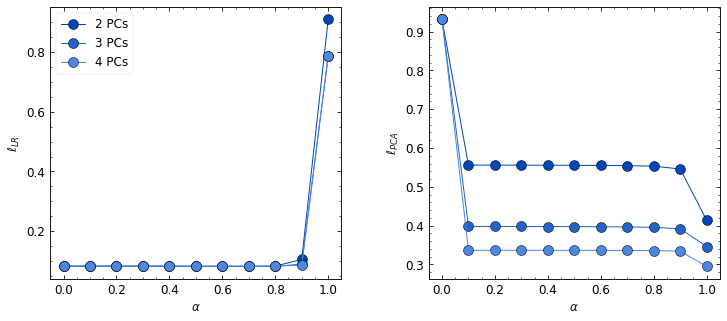

In [23]:
fig, [axsLR, axsPCA] = plt.subplots(1, 2, figsize=dbl_fig, sharex=True)

for cdx, c in enumerate(components):
    axsLR.plot(alphas, L_lr[cdx, :], marker='o', label='{:d} PCs'.format(c))
    axsPCA.plot(alphas,L_pca[cdx, :], marker='o', label='{:d} PCs'.format(c))

axsLR.set_ylabel(r'$\ell_{LR}$')
axsLR.set_xlabel(r'$\alpha$')
axsPCA.set_ylabel(r'$\ell_{PCA}$')
axsPCA.set_xlabel(r'$\alpha$')

fig.subplots_adjust(wspace=0.3)
axsLR.legend()
plt.show()

Given that the two terms vary in opposite directions (which is obvious, since $\alpha$ changes the way they contribute to the total loss), choosing a value implies making a tradeoff between LR and PCA performance. The least biased choice is then to look for the value that minimizes the (non-weighted) sum of the PCA and LR terms. 

This is the optimal choice if one gives equal importance to the two tasks, and is (roughly) equivalent to plotting a $\lambda$ curve -- i.e. a plot of $\ell_{LR}$ against $\ell_{PCA}$ for different values of the mixing $\alpha$ -- and looking for the elbow of the curve, that gives the value at which the improvement in the accuracy of one of the losses balance the degradation of the other.

Optimal alpha for 2 PCs = 0.80
Optimal alpha for 3 PCs = 0.80
Optimal alpha for 4 PCs = 0.80


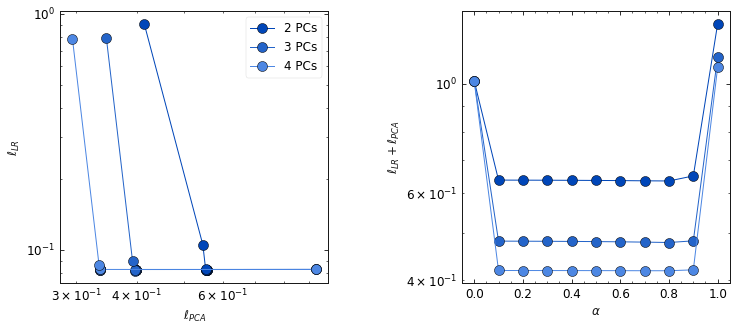

In [24]:
fig = plt.figure(figsize=dbl_fig)
axsLoss = fig.add_subplot(1, 2, 1)
axsSum = fig.add_subplot(1, 2, 2)

for cdx, c in enumerate(components):
    axsLoss.loglog(L_pca[cdx, :], L_lr[cdx, :], marker='o', label='{:d} PCs'.format(c))

axsLoss.set_xlabel(r'$\ell_{PCA}$')
axsLoss.set_ylabel(r'$\ell_{LR}$')
axsLoss.legend()

for cdx, c in enumerate(components):
    loss_sum = L_lr[cdx, :] + L_pca[cdx, :]
    axsSum.semilogy(alphas, loss_sum, marker='o', label='{:d} PCs'.format(c))
    print('Optimal alpha for {:d} PCs = {:.2f}'.format(c, alphas[np.argmin(loss_sum)]))
    
axsSum.set_xlabel(r'$\alpha$')
axsSum.set_ylabel(r'$\ell_{LR} + \ell_{PCA}$')

fig.subplots_adjust(wspace=0.5, hspace=0.3)
    
plt.show()

# Next: Kernel Methods

Continue on to the [next notebook](3_KernelMethods.ipynb)!

# The Utility Class

Classes from the utility module enable computing PCovR with a scikit.learn-like syntax. 

The PCovR class takes a parameter `space` to designate whether projectors should be computed in structure or feature space. If the parameter is not supplied, the class detects the shape of the input data when `pcovr.fit(X,Y)` is called and choose the most efficient method.

In [25]:
from utilities.classes import PCovR

In [26]:
alpha=0.5
pcovr = PCovR(alpha=alpha, n_PC=2)

In [27]:
pcovr.fit(X_train, Y_train)

# samples > # features, computing in feature space


`pcovr.transform(X)` returns the projection $\mathbf{T}$, regressed properties $\mathbf{Y}_p$ and the reconstructed input data $\mathbf{X}_r$.

In [28]:
t,y,x = pcovr.transform(X_test)

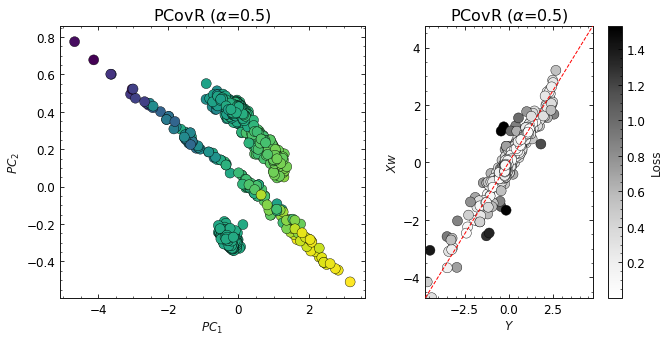

In [29]:
fig, ax = plt.subplots(1,2, figsize=dbl_fig)
plot_projection(Y_test, t, title = r"PCovR ($\alpha$={})".format(alpha), fig=fig, ax=ax[0], **cmaps)
plot_regression(Y_test[:,0], y[:,0], title = r"PCovR ($\alpha$={})".format(alpha), fig=fig, ax=ax[1], **cmaps)

`pcovr.statistics(X, Y)` provides the statistics. Here we compare them to LR and PCA.

In [30]:
# create and train reference LR and PCA,
# computed using PCovR(alpha=0.0) and PCovR(alpha=1.0)
 
ref_lr = PCovR(alpha=0.0, n_PC=n_PC)
ref_pca = PCovR(alpha=1.0, n_PC=n_PC)

ref_lr.fit(X_train, Y_train)
ref_pca.fit(X_train, Y_train)

table_from_dict([pcovr.statistics(X_test, Y_test), \
                 ref_lr.statistics(X_test, Y_test),
                 ref_pca.statistics(X_test, Y_test)
                ], \
                headers = ["PCovR", "LR", "PCA"])

# samples > # features, computing in feature space
# samples > # features, computing in feature space


<center><b>  </b></center><br>                            <center><table><tr><th></th><th><center>PCovR</center></th><th><center>LR</center></th><th><center>PCA</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> 0.917957 </td><td> 0.917402 </td><td> 0.0896899 </td></tr><tr><td> Regression Error </td>                                                <td> 0.00743922 </td><td> 0.00746435 </td><td> 0.02478 </td></tr><tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 0.478254 </td><td> 0.478254 </td><td> 0.478254 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 0.585502 </td><td> 0.958401 </td><td> 0.280545 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> -0.107248 </td><td> -0.480147 </td><td> 0.19771 </td></tr><tr><td> Representation Error </td>                                                <td> 0.265736 </td><td> 0.445754 </td><td> 0.197953 </td></tr></table></center>

This may appear confusing at first -- why is the projection variance smallest with PCA? To understand, consider that our projections $\mathbf{T}$ contain not only the variance of the dataset $\mathbf{X}$, but also a portion of that of the regressed properties $\hat{\mathbf{Y}}$.

In [31]:
pcovr.Yhat.var()

0.4748197619855746